<center><h1>Brain Tumor Detection 🧠</h1><center>

<img src="https://images.unsplash.com/photo-1559757175-0eb30cd8c063?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1031&q=80">

# Importing Essential Libraries and Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

# Loading the Data

We load the data by making use of the tool image_dataset_from directory. It helps us fetch the data from the relevant directory, automatically does labeling, shuffles the data, batches the data (in this case as 32) and resizes images into 256 by 256.

In [2]:
data = keras.utils.image_dataset_from_directory("../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")

Found 253 files belonging to 2 classes.


2022-08-22 11:49:09.294118: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<h3>Plotting a few Example Images</h3>

If a brain has tumor it is labeled as 1, if no it is labeled as 0.

In [3]:
batch = data.as_numpy_iterator().next()

2022-08-22 11:49:09.491282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


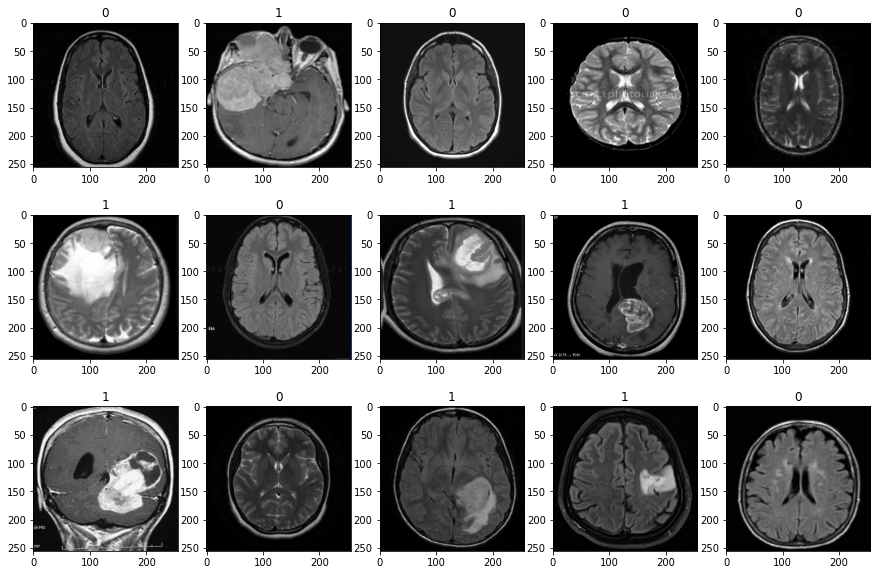

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data Scaling

Since our data consists of images and images consist of pixels, we divide all the pixel values by 255—each pixel can have a value in [0, 255]— so that all the pixel values are on the same scale i.e. [0, 1].

In [5]:
data = data.map(lambda x,y: (x/255, y))

In [6]:
batch = data.as_numpy_iterator().next()

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


In [7]:
print("Minimum value of the scaled data:", batch[0].min())
print("Maximum value of the scaled data:", batch[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


# Train-Validation-Test Split

In [8]:
print("There are", len(data), "batches in our data")

There are 8 batches in our data


Now, we have to divide the whole data into 3 separate sets: Train set for training the model, Validation set for adjusting the hyperparameters of our model and Test set for evaluating our model on the set that our model has not seen before. As it can be seen, we have 8 batches in our data. I preferred allocating 4 batches for Train set, 2 batches for Validation set and 2 batches for Test set.

In [9]:
train_size = int(len(data)*0.6)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.2)+1

In [10]:
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

print("Sum of Train, Validation and Test sizes is equal to:", train_size + val_size + test_size)

Train Size: 4
Validation Size: 2
Test Size: 2
Sum of Train, Validation and Test sizes is equal to: 8


In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Data Augmentation

Because our Train set has relatively small number of images, we can apply data augmentation which is reproducing the images by applying some changes such as random rotating, random flipping, random zoom and random contrast. This may possibly increase the accuracy score of the model. Since we will be applying the data augmentation in the beginning of the neural network architecture, we should pass the input shape.

Note: Data augmentation will be inactive when testing the data. Input images will be augmented during calls to model.fit (not model.evaluate or model.predict). If you want to learn more about data augmentation in Tensorflow, you can check the official documentation.

In [12]:
batch = data.as_numpy_iterator().next()

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


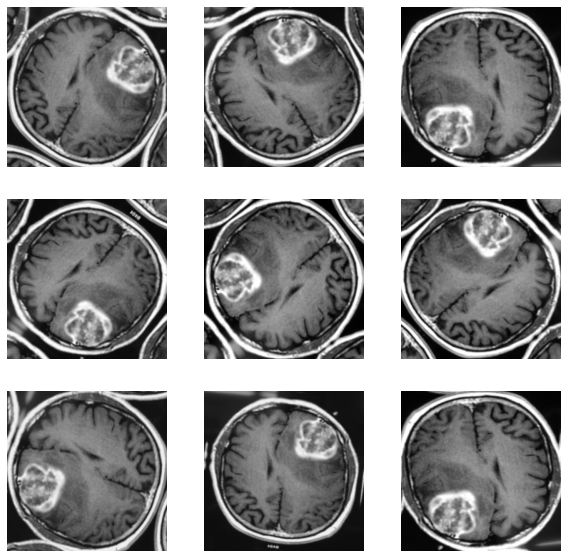

In [13]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

image = batch[0]


plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Building Deep Learning Model

In [14]:
model = Sequential([
    data_augmentation,
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [15]:
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)       

In [17]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.6250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 11s 2s/step - loss: 0.7703 - accuracy: 0.6250 - val_loss: 0.6861 - val_accuracy: 0.6875
Epoch 2/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6484

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6574 - accuracy: 0.6484 - val_loss: 0.5854 - val_accuracy: 0.6250
Epoch 3/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.6562

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6076 - accuracy: 0.6562 - val_loss: 0.6335 - val_accuracy: 0.6406
Epoch 4/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6484

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6151 - accuracy: 0.6484 - val_loss: 0.5965 - val_accuracy: 0.7500
Epoch 5/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7031

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.5965 - accuracy: 0.7031 - val_loss: 0.5736 - val_accuracy: 0.7344
Epoch 6/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.6953

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 8s 2s/step - loss: 0.5740 - accuracy: 0.6953 - val_loss: 0.5777 - val_accuracy: 0.7344
Epoch 7/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.6953

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.5608 - accuracy: 0.6953 - val_loss: 0.5344 - val_accuracy: 0.7031
Epoch 8/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.7266

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6191 - accuracy: 0.7266 - val_loss: 0.5096 - val_accuracy: 0.8125
Epoch 9/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.5465 - accuracy: 0.8125 - val_loss: 0.5831 - val_accuracy: 0.7656
Epoch 10/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.7891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 8s 2s/step - loss: 0.5527 - accuracy: 0.7891 - val_loss: 0.4703 - val_accuracy: 0.7812
Epoch 11/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6797

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6026 - accuracy: 0.6797 - val_loss: 0.5526 - val_accuracy: 0.7500
Epoch 12/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.7031

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6201 - accuracy: 0.7031 - val_loss: 0.5840 - val_accuracy: 0.7188
Epoch 13/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.7344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 8s 2s/step - loss: 0.5660 - accuracy: 0.7344 - val_loss: 0.4329 - val_accuracy: 0.8281
Epoch 14/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6797

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.6170 - accuracy: 0.6797 - val_loss: 0.5859 - val_accuracy: 0.6719
Epoch 15/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.7344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


4/4 [==============================] - 9s 2s/step - loss: 0.5861 - accuracy: 0.7344 - val_loss: 0.5680 - val_accuracy: 0.7812


# Plotting the Performance

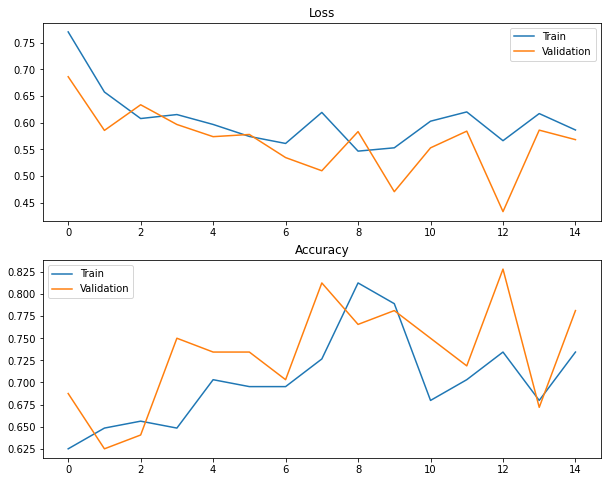

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

# Results

In [19]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Accuracy:", bin_acc.result().numpy(), "\nRecall:", recall.result().numpy(), "\nPrecision:", precision.result().numpy())

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


Accuracy: 0.8356681 
Recall: 0.82051283 
Precision: 0.9142857


# Manual Testing

We have already evaluated our model using various metrics and visualizations but it is always a good practice to test the model by hand to make sure everything is working well. In the code below, I randomly chose an image and plotted it with its true label on title so let's see if our model is going to classify this example correctly.

In [20]:
batch = test.as_numpy_iterator().next()

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


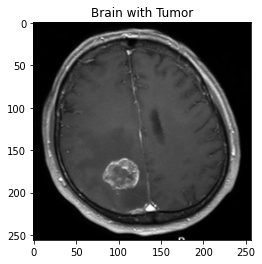

In [21]:
img, label = batch[0][15], batch[1][15]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [22]:
y_hat = model.predict(np.expand_dims(img, 0))

We are able to see the probability of this brain's having tumor below. I opted to determine the classification threshold as 0.5. Meaning that, if it is below 0.5 this will be classified as Brain Having No Tumor otherwise it is going to be classified as Brain Having Tumor.

In [23]:
y_hat

array([[0.6768608]], dtype=float32)

In [24]:
if y_hat < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

Tumor detected


Here we can see that our model predicted its class correctly.